## LSTM을 활용한 주가 예측 모델

### FinanceDataReader 설치

In [1]:
!pip install finance-datareader

### 모듈 import

In [2]:
import FinanceDataReader as fdr

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore') # 경고메세지 무시

plt.rcParams['font.family'] = 'NanumGothic' # 한글 폰트 설정

### 삼성전자(005930) 주가 데이터를 DataFrame으로 받아오기

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [4]:
STOCK_CODE='005930' # 삼성전자 주식코드

In [5]:
stock=fdr.DataReader(STOCK_CODE)

In [6]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-05-18,1206,1226,1165,1177,255210,NaN
1998-05-19,1163,1171,1118,1138,434310,-0.033135
1998-05-20,1145,1161,1126,1130,352676,-0.007030
1998-05-21,1130,1139,1061,1061,605730,-0.061062
1998-05-22,1029,1042,1014,1026,465530,-0.032988


In [7]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-07-18,60600,62000,60500,61900,20832517,0.031667
2022-07-19,61400,61500,60200,60900,15248261,-0.016155
2022-07-20,61800,62100,60500,60500,16782238,-0.006568
2022-07-21,61100,61900,60700,61800,12291374,0.021488
2022-07-22,61800,62200,61200,61400,8542051,-0.006472


In [8]:
stock.index

DatetimeIndex(['1998-05-18', '1998-05-19', '1998-05-20', '1998-05-21',
               '1998-05-22', '1998-05-23', '1998-05-25', '1998-05-26',
               '1998-05-27', '1998-05-28',
               ...
               '2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14',
               '2022-07-15', '2022-07-18', '2022-07-19', '2022-07-20',
               '2022-07-21', '2022-07-22'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

In [9]:
len(stock.index)

6000

index가 `DatetimeIndex`로 지정되어 있다.

`DatetimeIndex`를 연,월,일로 쪼개면 **월별, 연도별 피벗데이터**를 만들 때 유용하게 활용할 수 있다.

In [10]:
stock['Year']=stock.index.year # 연
stock['Month']=stock.index.month # 월
stock['Day']=stock.index.day # 일

In [11]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1998-05-18,1206,1226,1165,1177,255210,NaN,1998,5,18
1998-05-19,1163,1171,1118,1138,434310,-0.033135,1998,5,19
1998-05-20,1145,1161,1126,1130,352676,-0.007030,1998,5,20
1998-05-21,1130,1139,1061,1061,605730,-0.061062,1998,5,21
1998-05-22,1029,1042,1014,1026,465530,-0.032988,1998,5,22


### 시각화

#### close열에 대한 그래프 그리기

Text(0, 0.5, 'price')

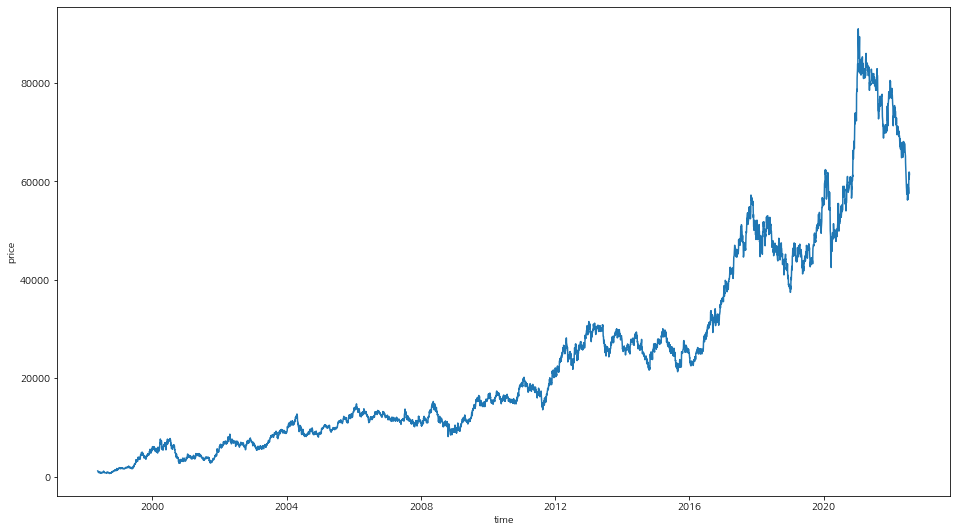

In [12]:
plt.figure(figsize=(16,9))
sns.lineplot(y=stock['Close'],x=stock.index) # y:종가, x:index(날짜)
plt.xlabel('time')
plt.ylabel('price')

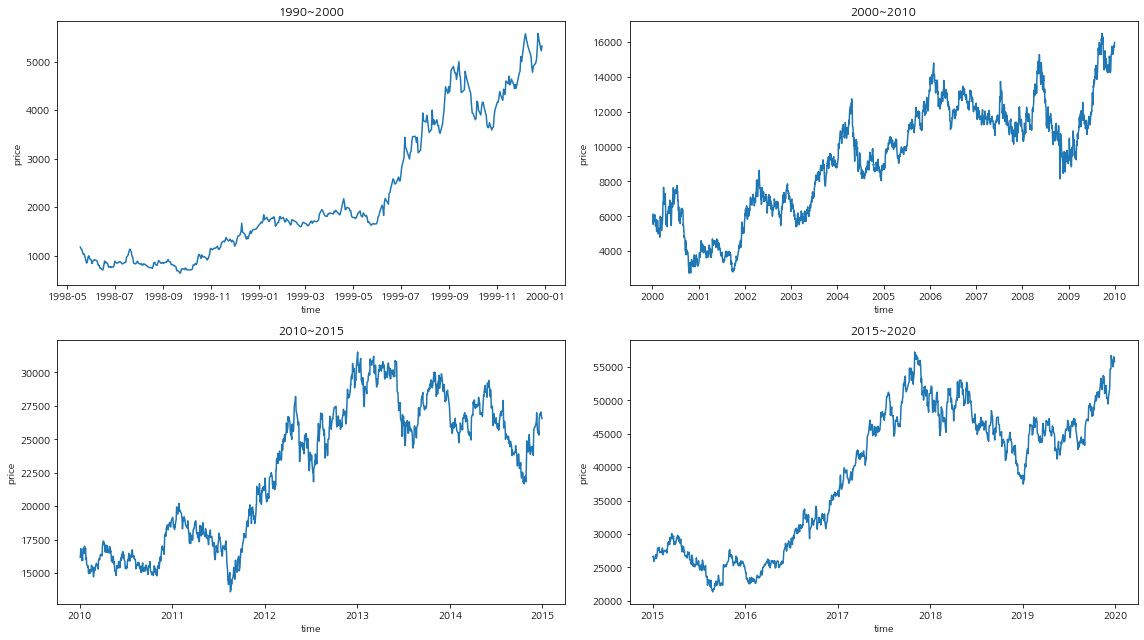

In [13]:
time_steps=[['1990','2000'], # 1990년부터 2000년
            ['2000','2010'], # 2000년부터 2010년
            ['2010','2015'], # 2010년부터 2015년
            ['2015','2020']] # 2015년부터 2020년

fig, axes=plt.subplots(2,2) # 2행 2열
fig.set_size_inches(16,9)
for i in range(4):
    ax=axes[i//2,i%2] # i=0,axes[0,0] / i=1,axes[0,1] / i=2,axes[1,0] / i=3,axes[1,1]
    df=stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])] # time_steps에서 한 개씩 불러와서 ex) 1990보다 크고 2000보다 작은 stock의 index를 가져옴
    sns.lineplot(y=df['Close'],x=df.index,ax=ax) # y=종가, x=index(날짜), ax=그래프가 그려질 위치
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}') # 제목
    ax.set_xlabel('time') # x축 이름
    ax.set_ylabel('price') # y축 이름

plt.tight_layout() # subplot들이 겹치지 않도록 최소한의 여백을 만들어줌
plt.show()

### 데이터 전처리

Open,High,Low,Close,Volume열에 대한 스케일링

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scale_cols=['Open','High','Low','Close','Volume'] # 스케일 적용할 column
scaled=scaler.fit_transform(stock[scale_cols]) # 스케일 적용
scaled

array([[0.01335548, 0.01266529, 0.01301676, 0.0059649 , 0.00282605],
       [0.01287929, 0.01209711, 0.01249162, 0.0055333 , 0.00480931],
       [0.01267996, 0.0119938 , 0.01258101, 0.00544477, 0.00390534],
       ...,
       [0.68438538, 0.64152893, 0.67597765, 0.66246874, 0.1858371 ],
       [0.67663344, 0.63946281, 0.67821229, 0.67685532, 0.13610779],
       [0.68438538, 0.64256198, 0.68379888, 0.67242868, 0.09458989]])

스케일이 완료된 column으로 새로운 데이터프레임 생성하기

6,000개의 행, 5개의 열로 이루어진 데이터셋

In [15]:
df=pd.DataFrame(scaled,columns=scale_cols)
df

,Open,High,Low,Close,Volume
0,0.013355,0.012665,0.013017,0.005965,0.002826
1,0.012879,0.012097,0.012492,0.005533,0.004809
2,0.012680,0.011994,0.012581,0.005445,0.003905
3,0.012514,0.011767,0.011855,0.004681,0.006708
4,0.011395,0.010764,0.011330,0.004294,0.005155
...,...,...,...,...,...
5995,0.671096,0.640496,0.675978,0.677962,0.230688
5996,0.679956,0.635331,0.672626,0.666895,0.168851
5997,0.684385,0.641529,0.675978,0.662469,0.185837
5998,0.676633,0.639463,0.678212,0.676855,0.136108


### train/test 분할

In [16]:
from sklearn.model_selection import train_test_split

- x: Close 열(axis=1)을 drop한 데이터프레임
- y: Close 열
- train:test 데이터비율 8:2

In [17]:
x_train,x_test,y_train,y_test=train_test_split(df.drop('Close',1),df['Close'],test_size=0.2,random_state=0,shuffle=False)

In [18]:
x_train.shape,y_train.shape

((4800, 4), (4800,))

In [19]:
x_test.shape,y_test.shape

((1200, 4), (1200,))

In [20]:
x_train

,Open,High,Low,Volume
0,0.013355,0.012665,0.013017,0.002826
1,0.012879,0.012097,0.012492,0.004809
2,0.012680,0.011994,0.012581,0.003905
3,0.012514,0.011767,0.011855,0.006708
4,0.011395,0.010764,0.011330,0.005155
...,...,...,...,...
4795,0.520709,0.488017,0.513520,0.002206
4796,0.505426,0.476033,0.504581,0.002796
4797,0.513621,0.479339,0.513520,0.001664
4798,0.511849,0.481818,0.513966,0.002439


In [21]:
y_train

0       0.005965
1       0.005533
2       0.005445
3       0.004681
4       0.004294
          ...   
4795    0.503110
4796    0.502888
4797    0.504216
4798    0.505544
4799    0.507315
Name: Close, Length: 4800, dtype: float64

In [22]:
print(type(x_train)) # 데이터 프레임
print(type(y_train)) # 시리즈

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


## TensorFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [23]:
import tensorflow as tf

windowed_data 함수 정의

In [24]:
def windowed_dataset(series,window_size,batch_size,shuffle):
    series=tf.expand_dims(series, axis=1) # 열방향으로 1차원 확장
    ds=tf.data.Dataset.from_tensor_slices(series)
    ds=ds.window(window_size+1, shift=1, drop_remainder=True)
    # WINDOW_SIZE=20이므로 +1 21개씩 그룹짓고, 한칸씩 이동, 21개 구성안되면 버리기
    ds=ds.flat_map(lambda w:w.batch(window_size+1))
    # ds 데이터프레임에서 window_size+1개만큼 꺼내온다
    if shuffle:
        ds=ds.shuffle(1000) # 1000개 섞기
    ds=ds.map(lambda w : (w[:-1],w[-1])) # 마지막거빼고 그 앞까지(~20개),마지막(21번) => 20일까지의 데이터로 21일째 가격을 예측
    return ds.batch(batch_size).prefetch(1)

하이퍼파라미터 정의

In [25]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [26]:
train_data=windowed_dataset(y_train,WINDOW_SIZE,BATCH_SIZE,True) # 훈련데이터
test_data=windowed_dataset(y_test,WINDOW_SIZE,BATCH_SIZE,False) # 검증데이터

In [27]:
for data in train_data.take(1): # 1개를 가져옴
    print(f'데이터셋(X) 구성(batch_size,window_size,feature갯수): {data[0].shape}') # 21개 중 20개를 x로 사용
    print(f'데이터셋(Y) 구성(batch_size,window_size,feature갯수): {data[1].shape}') # 마지막 1개를 y로 사용

데이터셋(X) 구성(batch_size,window_size,feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size,window_size,feature갯수): (32, 1)


## 모델

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [29]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [30]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt') # 파일이름
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [31]:
history = model.fit(train_data, # 훈련
                    validation_data=(test_data), # 검증 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    150/Unknown - 8s 18ms/step - loss: 7.0228e-05 - mse: 1.4046e-04
Epoch 1: val_loss improved from inf to 0.00033, saving model to tmp\ckeckpointer.ckpt
150/150 [==============================] - 13s 51ms/step - loss: 7.0228e-05 - mse: 1.4046e-04 - val_loss: 3.3248e-04 - val_mse: 6.6496e-04
Epoch 2/50
148/150 [============================>.] - ETA: 0s - loss: 2.3720e-05 - mse: 4.7440e-05
Epoch 2: val_loss did not improve from 0.00033
150/150 [==============================] - 4s 24ms/step - loss: 2.3700e-05 - mse: 4.7400e-05 - val_loss: 3.7766e-04 - val_mse: 7.5532e-04
Epoch 3/50
148/150 [============================>.] - ETA: 0s - loss: 2.2343e-05 - mse: 4.4686e-05
Epoch 3: val_loss improved from 0.00033 to 0.00028, saving model to tmp\ckeckpointer.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 2.2523e-05 - mse: 4.5046e-05 - val_loss: 2.7767e-04 - val_mse: 5.5534e-04
Epoch 4/50
149/150 [============================>.] - ETA: 0s - loss: 2.2079e-05 - ms

저장한 ModelCheckpoint를 로드

In [32]:
model.load_weights(filename)

test_data를 활용하여 예측

In [33]:
pred = model.predict(test_data)

37/37 [==============================] - 1s 9ms/step


In [34]:
pred.shape

(1180, 1)

## 예측 데이터 시각화

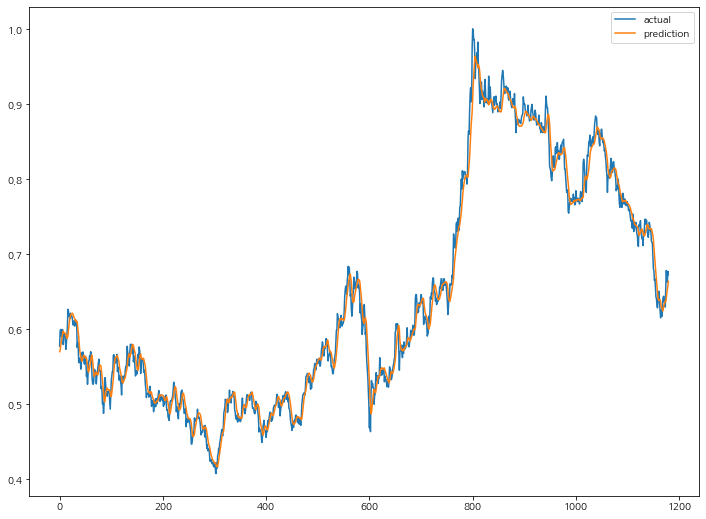

In [35]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual') # 21일을 예측
plt.plot(pred, label='prediction')
plt.legend()
plt.show()